In [1]:
!date
!python --version

Tue Jun 25 12:10:13 AM UTC 2024
Python 3.10.12


# AutoModelForSequenceClassificationを用いたファインチューニング例
このノートブックでは[Japanese Realistic Textual Entailment Corpus](https://github.com/megagonlabs/jrte-corpus)のpn.tsvをデータセットとし、BERT（"tohoku-nlp/bert-base-japanese-v3"）を用いてファインチューニングする例を示している。全体の流れは以下の通り。

- 環境構築: fugashi, accelerateをインストール
- モジュール読み込み
- データ前処理: LLMにおける分類タスクでは教師ラベルを「0から始まる整数」として割り振る必要があるため、ラベルを設定し直した。
- モデルの用意: tokenizerの動作確認を含む。
- LLM用にデータを整形: tokenizerの出力と教師ラベルを合わせてDataset型に変換。
- 学習
- テストデータに対する詳細結果
- 学習データに対する詳細結果

## 注意
### GPUを指定する
LLMを用いた学習を行っている都合上、デフォルト（CPU）実行すると極めて時間がかかる。おそらく数時間要するだろう。今回はGPUを指定して実行することを強くお勧めする。

GPUを指定するには以下の手順を取る。
- 「ランタイム」から「ランタイムのタイプの変更」を選ぶ。
- 「ハードウェア アクセラレータ」からGPUを選ぶ。
  - T4 GPU を選ぶと良い。この中では低スペックだが十分早い。T4 GPUなら、10エポックの学習が約14分で終了する。

### リソース使用制限
Google Colabは無料で利用できるが、利用度合いに応じてリソースが制限されることがある。特にGPUは使えなくなることが多いため、不必要に何度も実行することは避けよう。

詳細: [最適な Colab のプランを選択する](https://colab.research.google.com/signup/pricing?hl=ja)

### 必要に応じてモデルや結果をファイル保存する
このノートブックではノートブック内に出力しつつ、学習したモデルはセッション内に保存しているだけで終えている。このため後日「学習結果を利用したい」場合には改めて学習し直す必要がある。それが面倒に思う人はファイル保存するようにしよう。

なお、正確には「ファイル」ではなく「複数のファイルを含むフォルダ」として保存されている。このフォルダ単位でダウンロードしたり、アップロードしてモデルを復元する必要があることに注意しよう。

またモデルはとてもファイルサイズが大きく、実際にダウンロード＆アップロードするにはとても時間がかかる。そのためGoogleドライブにアクセス許可した上で自身のドライブ内に保存する方が楽だ。

```Python
# ノートブックからドライブへのアクセスを許可する
from google.colab import drive
drive.mount('/content/drive')
```

## 環境構築

In [2]:
!pip install fugashi[unidic-lite]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=93d9fb07131b7a11f3fd9f21e93759a181788374dd53f0d53f41d0e0bcba855b
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x

## モジュール読み込み、データ前処理

In [4]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# データの読み込み
filename = "pn.tsv"
columns = ["id", "sentiment", "text", "judges-json", "usage"]
df = pd.read_csv(filename, sep="\t", names=columns)

# ラベルの付け替え
# AutoModelForSequenceClassificationではラベルは「0から始まる整数」である必要がある。
# このため -1, 0, 1 => 0, 1, 2（ネガティブ0、ノーマル1、ポジティブ2）に付け替える。
df['sentiment'] = df['sentiment'].map({-1: 0, 0: 1, 1: 2})

# データセットの分割
train_texts = df[df["usage"] == "train"]["text"].tolist()
train_labels = df[df["usage"] == "train"]["sentiment"].tolist()
dev_texts = df[df["usage"] == "dev"]["text"].tolist()
dev_labels = df[df["usage"] == "dev"]["sentiment"].tolist()
test_texts = df[df["usage"] == "test"]["text"].tolist()
test_labels = df[df["usage"] == "test"]["sentiment"].tolist()

# 動作確認
print(f"{train_texts[0]=}")
print(f"{train_labels[0]=}")
print(df['sentiment'].value_counts())

train_texts[0]='(笑)'
train_labels[0]=1
sentiment
2    3406
1    1329
0     818
Name: count, dtype: int64


## モデルの用意
- ここでは "tohoku-nlp/bert-base-japanese-v3" を利用。
- 長文だが、最初の出力「`Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']   You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.`」は、このままでは利用できない（ので学習が必要だろう）ということを指摘している。この理由は、AutoModelForSequenceClassificationが「LLMの最後尾に新たな線形層（[torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)）を追加しているためだ。この線形層はクラス数と同数のユニットを持つように設定されており（引数num_labelsで設定）、各ユニットに対するスコアを求めるようにモデルを拡張している。
- このようなにモデルを拡張しているということは、拡張した部分（Linear層のパラメータ）については重みがまっさらな状態である。このままでは当然推定できない（でたらめになる）ため、「You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.」と注意を促している。
- TrainingArgumentsで用いているパラメータ output_dir はチェックポイントを保存する場所を指定している。
  - チェックポイントとは、別のパラメータ「save_strategy = "epoch"」として指定したタイミングのモデルのこと。今回はepochと指定しているため1エポック毎にモデルが保存されている。
  - 必要に応じてこれらのチェックポイントからモデルを復元することも可能。モデル読み込み時にファイルを指定するだけで良い。このためファインチューニングしたモデルをファイル保存しておきたいならば、resultsフォルダ内のチェックポイントを保存しておくか、最終モデルである sentiment_model を保存しておくと良いだろう。
  - ダウンロードするというよりは、Googleドライブへのアクセス許可を与え、自身のドライブ内に保存する方が良いだろう。

In [5]:
# ハイパーパラメータ
num_labels = 3   # クラス数
max_length = 128 # 最長系列長（最大トークン数）
num_train_epochs = 10 # 最大学習エポック数
output_dir = './results' # チェックポイント等を保存するディレクトリ
batch_size = 16  # バッチサイズ（一度に処理するサンプル数）
logging_dir = './logs' # ログ出力用のディレクトリ（主にエラー確認用）

# トークナイザーとモデルの準備
model_name = "tohoku-nlp/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# データセットのトークナイズ
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

# 動作確認
# 'input_ids', 'token_type_ids', 'attention_mask'をキーとするリストとして保存されている。
# ['input_ids'][0] は、0番目のみを出力指定。
print(train_encodings.keys())
print(train_encodings['input_ids'][0]) # サンプル0番目
print(train_encodings['attention_mask'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[2, 23, 4374, 24, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
# input_ids をデコードして確認
tokenizer.decode([2, 23, 4374, 24, 3])

'[CLS] ( 笑 ) [SEP]'

## LLM用にデータを整形
今回は分類タスクとして学習させたい。しかしtokenizerではテキストに対する前処理しか行われておらず、教師ラベルは別に用意している。これらを使いやすい形（Dataset型）にまとめ直している。

In [7]:
class SentimentDataset(torch.utils.data.Dataset):
    '''サンプル毎に input_ids, token_type_ids, attention_mask, labels を設定。
    '''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
dev_dataset = SentimentDataset(dev_encodings, dev_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# 動作確認
# サンプル毎に input_ids, token_type_ids, attention_mask, labels を用意した
print(train_dataset[0])

{'input_ids': tensor([   2,   23, 4374,   24,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_ma

## 学習
エポック毎に出力しているログは、学習データに対する損失(training loss)、検証データに対する損失(validation loss)、正解率(accuracy)、F1スコア(F1)、適合率(precision)、再現率(recall)。

ログを確認すると、基本的には学習データに対する損失は減り続けている。しかし検証データに対する損失は途中から「逆に増えている」ことを確認できる。これが[過学習（過剰適合; over-fitting）](https://en.wikipedia.org/wiki/Overfitting#Machine_learning)だ。ここでは特別なことはせずに指定したエポック数の学習を続け、最終もでエルを用いた検証を行うこととした。

In [8]:
# トレーニングの設定
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

# 精度の計算
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='macro')
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# トレーナーの設定
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

# モデルのトレーニング
trainer.train()

# モデルの保存
trainer.save_model("./sentiment_model")

# テストセットでの評価
results = trainer.evaluate(eval_dataset=test_dataset)

# 結果の表示
print(f"Test Accuracy: {results['eval_accuracy']}")
print(f"Test F1 Score: {results['eval_f1']}")
print(f"Test Precision: {results['eval_precision']}")
print(f"Test Recall: {results['eval_recall']}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.423400,0.390626,0.853417,0.805778,0.821309,0.797058
2,0.302400,0.344628,0.865108,0.825983,0.837619,0.819292
3,0.173600,0.460407,0.876799,0.835589,0.841920,0.836759
4,0.225100,0.523901,0.873201,0.833102,0.834192,0.834772
5,0.084000,0.573181,0.879496,0.840015,0.842462,0.838103
6,0.006300,0.743830,0.859712,0.817780,0.816659,0.820234
7,0.028300,0.777815,0.884892,0.849863,0.851610,0.848161
8,0.013500,0.806769,0.890288,0.855647,0.862244,0.850295
9,0.000800,0.849699,0.886691,0.850617,0.854837,0.847571
10,0.001900,0.856102,0.884892,0.847907,0.854275,0.843427


Test Accuracy: 0.8607594936708861
Test F1 Score: 0.8308946761001555
Test Precision: 0.8580621695594958
Test Recall: 0.8097126694248997


## テストデータに対する詳細結果

In [13]:
# テストデータに対する詳細結果
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#import numpy as np

predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
labels = ['negative', 'normal', 'positive']

# 分類レポートの表示
print(classification_report(test_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

    negative       0.93      0.81      0.86        78
      normal       0.77      0.67      0.72       139
    positive       0.88      0.95      0.91       336

    accuracy                           0.86       553
   macro avg       0.86      0.81      0.83       553
weighted avg       0.86      0.86      0.86       553



Text(0.5, 1.0, 'Confusion Matrix')

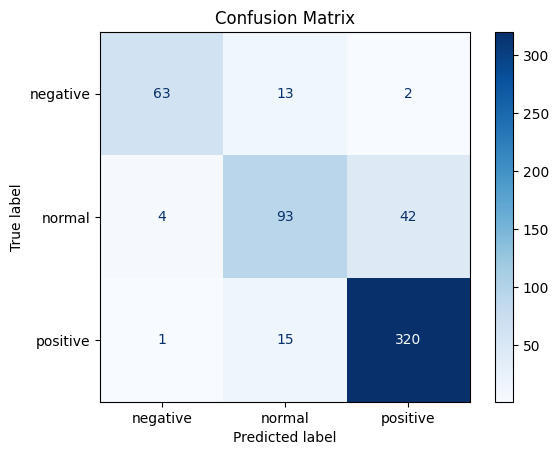

In [15]:
# 混同行列の表示
conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')

## 具体的な失敗例
ラベルは「ネガティブ0、ノーマル1、ポジティブ2」に付け直していることに注意。

### 学習データに対する誤り
以下の通り1件しか誤りがない。学習データに対しては極めて的鉄な予測が可能なモデルになっているようだ。

In [16]:
# 学習データに対する予測誤り

predictions, labels, _ = trainer.predict(train_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# 誤った予測のサンプルを抽出
incorrect_indices = [i for i, (true, pred) in enumerate(zip(train_labels, predicted_labels)) if true != pred]

# 誤った予測のサンプルを出力
for i in incorrect_indices:
    print(f"正解ラベル: {train_labels[i]}, 予測ラベル: {predicted_labels[i]}, テキスト: {train_texts[i]}")

正解ラベル: 0, 予測ラベル: 1, テキスト: 気持ち悪くて食べられませんでした。


### テストデータに対する誤り
テストデータのサンプル数は学習データより少ないにも関わらず、失敗事例数は多い。

In [18]:
# テストデータに対する予測誤り

predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# 誤った予測のサンプルを抽出
incorrect_indices = [i for i, (true, pred) in enumerate(zip(test_labels, predicted_labels)) if true != pred]

# 誤った予測のサンプルを出力
for i in incorrect_indices:
    print(f"正解ラベル: {test_labels[i]}, 予測ラベル: {predicted_labels[i]}, テキスト: {test_texts[i]}")

正解ラベル: 1, 予測ラベル: 2, テキスト: お心遣いありがとうございました。
正解ラベル: 0, 予測ラベル: 1, テキスト: と感じてしまいました。
正解ラベル: 2, 予測ラベル: 1, テキスト: 再訪です。
正解ラベル: 2, 予測ラベル: 1, テキスト: 二度目です。
正解ラベル: 1, 予測ラベル: 2, テキスト: お疲れ様です。
正解ラベル: 1, 予測ラベル: 2, テキスト: (^ω^
正解ラベル: 1, 予測ラベル: 2, テキスト: 対応ありがとうございました。
正解ラベル: 1, 予測ラベル: 2, テキスト: コンビニも近かったです。
正解ラベル: 1, 予測ラベル: 2, テキスト: 長々と失礼しました。
正解ラベル: 1, 予測ラベル: 2, テキスト: 寝るだけなので十分です。
正解ラベル: 1, 予測ラベル: 2, テキスト: が感想です。
正解ラベル: 0, 予測ラベル: 1, テキスト: 朝食は食べませんでした。
正解ラベル: 1, 予測ラベル: 2, テキスト: 良かった所。
正解ラベル: 1, 予測ラベル: 2, テキスト: 安心してください。
正解ラベル: 1, 予測ラベル: 2, テキスト: 思わず笑ってしまいました。
正解ラベル: 2, 予測ラベル: 1, テキスト: 間違いないホテルです。
正解ラベル: 2, 予測ラベル: 1, テキスト: 迷わず予約しました。
正解ラベル: 1, 予測ラベル: 2, テキスト: 足湯もありました。
正解ラベル: 1, 予測ラベル: 2, テキスト: 料理は期待通りでした。
正解ラベル: 0, 予測ラベル: 1, テキスト: 結局入れなかった。
正解ラベル: 1, 予測ラベル: 2, テキスト: また機会があれば...。
正解ラベル: 1, 予測ラベル: 2, テキスト: 朝食付きをお勧めします。
正解ラベル: 1, 予測ラベル: 2, テキスト: 立地はまずまず。
正解ラベル: 2, 予測ラベル: 1, テキスト: そんなに気になりませんでした。
正解ラベル: 2, 予測ラベル: 1, テキスト: 立地は問題なしです。
正解ラベル: 0, 予測ラベル: 2, テキスト: 食べたかったなぁ。
正解ラベル: 0, 予測ラベル: 1, テキスト: 天気は雨。
正解ラベル: 